🚀 Starting Zero-Shot Baseline (No Training)...
   Evaluating on 500 validation images.
   Running Inference...


  0%|          | 0/16 [00:00<?, ?it/s]


🏆 ZERO-SHOT BASELINE RESULTS
AUC:          0.4432
Sensitivity:  0.8750
Specificity:  0.1690


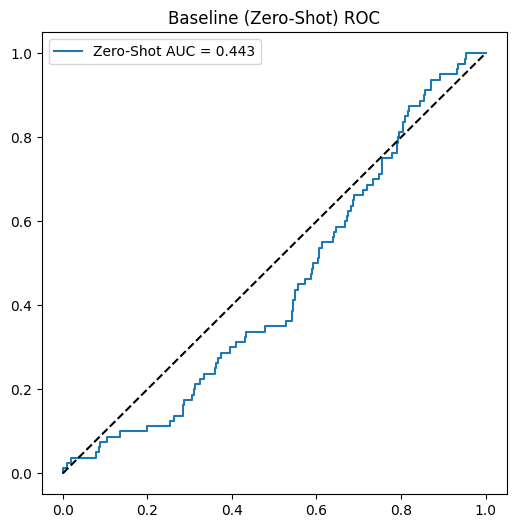

In [9]:
# ============================================================================
# ZERO-SHOT BASELINE (FIXED DATALOADER)
# ============================================================================
import os
import sys
import warnings
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass

# Install dependencies if missing
os.system('pip install -q "numpy==1.26.4" "scikit-learn==1.3.2" "albumentations==1.3.1" "opencv-python-headless<4.9" "transformers==4.42.0" "peft==0.11.0" "timm" "protobuf==3.20.3"')

os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings("ignore")

@dataclass
class Config:
    csv_path: str = "/kaggle/input/siim-isic-melanoma-classification/train.csv"
    img_dir: str = "/kaggle/input/siim-isic-melanoma-classification/jpeg/train"
    clip_model: str = "openai/clip-vit-base-patch32"
    sample_size: int = 2500
    min_malignant: int = 400
    batch_size: int = 32
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

config = Config()

# --- DATA PREP ---
def get_data_splits():
    if not os.path.exists(config.csv_path):
        for root, dirs, files in os.walk("/kaggle/input"):
            if "train.csv" in files: config.csv_path = os.path.join(root, "train.csv")
            if "jpeg" in dirs: config.img_dir = os.path.join(root, "jpeg", "train")
            elif "train" in dirs: config.img_dir = os.path.join(root, "train")

    df = pd.read_csv(config.csv_path)
    m_df = df[df['target']==1].sample(n=min(len(df[df['target']==1]), config.min_malignant), random_state=42)
    b_df = df[df['target']==0].sample(n=min(len(df[df['target']==0]), config.sample_size - len(m_df)), random_state=42)
    df_main = pd.concat([m_df, b_df]).sample(frac=1, random_state=42)
    
    _, val_df = train_test_split(df_main, test_size=0.2, stratify=df_main['target'], random_state=42)
    return val_df

# --- DATASET ---
class ZeroShotDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.img_dir, row['image_name'] + '.jpg')
        if not os.path.exists(path): path = path.replace('.jpg', '')
        # Return raw image and label
        return Image.open(path).convert('RGB'), row['target']

# --- CUSTOM COLLATE FUNCTION (THE FIX) ---
# This prevents the DataLoader from crashing when trying to stack Images
def collate_fn(batch):
    images = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])
    return images, labels

def main():
    print("🚀 Starting Zero-Shot Baseline (No Training)...")
    val_df = get_data_splits()
    print(f"   Evaluating on {len(val_df)} validation images.")
    
    # Load CLIP
    model = CLIPModel.from_pretrained(config.clip_model).to(config.device)
    processor = CLIPProcessor.from_pretrained(config.clip_model)
    model.eval()
    
    # Define Zero-Shot Prompts
    class_prompts = ["a benign skin lesion", "a malignant melanoma"]
    
    # Pre-encode text prompts
    inputs_text = processor(text=class_prompts, return_tensors="pt", padding=True).to(config.device)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs_text)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    # Run Inference
    ds = ZeroShotDataset(val_df, config.img_dir)
    # FIX: Added collate_fn and set num_workers=0
    loader = DataLoader(ds, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn)
    
    probs = []
    targets = []
    
    print("   Running Inference...")
    with torch.no_grad():
        for images, labels in tqdm(loader):
            # Process list of images using processor
            image_inputs = processor(images=images, return_tensors="pt", padding=True).to(config.device)
            image_features = model.get_image_features(**image_inputs)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            
            # Calculate similarity
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            
            # Take probability of Class 1 (Malignant)
            probs.extend(similarity[:, 1].cpu().numpy())
            targets.extend(labels.numpy())
            
    # Metrics
    auc = roc_auc_score(targets, probs)
    preds = [1 if p > 0.5 else 0 for p in probs]
    tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    
    print("\n" + "="*40)
    print("🏆 ZERO-SHOT BASELINE RESULTS")
    print("="*40)
    print(f"AUC:          {auc:.4f}")
    print(f"Sensitivity:  {sens:.4f}")
    print(f"Specificity:  {spec:.4f}")
    print("="*40)
    
    # Plot ROC
    
    plt.figure(figsize=(6, 6))
    fpr, tpr, _ = roc_curve(targets, probs)
    plt.plot(fpr, tpr, label=f"Zero-Shot AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("Baseline (Zero-Shot) ROC")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()